# 0. Configuration

In [457]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'
RATINGS_SMALL_URL = 'https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link'
KEYWORDS = 'https://drive.google.com/file/d/16TV3-KX9EYCcEcajvTh8MJqOij6EF67W/view'

# 1. Modules and functions

In [458]:
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# download stop words beforehand
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitasenyatkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.1. Helper functions to avoid copypaste

In [459]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

In [460]:
# init lemmatizer to avoid slow performance
mystem = Mystem() 

def word_tokenize_clean(doc: str, stop_words: list):
    '''
    tokenize from string to list of words
    '''

    # split into lower case word tokens \w lemmatization
    tokens = list(set(mystem.lemmatize(doc.lower())))
  
    # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words \
              not in list(punctuation)]
    return tokens

# 2. Main

## 2.1. Data Preparation

In [461]:
# read csv information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [462]:
# let's see what columns we have
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

To get accurate results we need to preprocess text a bit. The pipeline will be as follows:

- Filter only necessary columns from movies_metadada : id, original_title, overview;
- Define `model_index` for model to match back with `id` column;
- Text cleaning: removing stopwords & punctuation, lemmatization for further tokenization and tagged document creatin required for gensim.Doc2Vec

In [463]:
# filter cols
sample = movies_metadata[['id', 'original_title', 'overview']].copy()
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [464]:
# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.isnull().sum()

id                0
original_title    0
overview          0
dtype: int64

In [465]:
# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

In [466]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [467]:
# preprocess by removing non-character data, stopwords
tags_corpus = sample['overview'].values
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
tags_doc[:5]

[['happily',
  'toys',
  'eventually',
  'andy',
  'duo',
  'birthday',
  'woody',
  'aside',
  'circumstances',
  'plots',
  'place',
  'brings',
  'heart',
  'afraid',
  'separate',
  'scene',
  'losing',
  'owner',
  'buzz',
  'live',
  'led',
  'lightyear',
  'room',
  'differences',
  'learns',
  'put',
  'onto'],
 ['invite',
  'enchanted',
  'finish',
  'find',
  'board',
  'door',
  'hope',
  'living',
  'running',
  'three',
  'siblings',
  'game',
  'world',
  'creatures',
  'proves',
  'monkeys',
  'years',
  'adult',
  'rhinoceroses',
  'unwittingly',
  'inside',
  'magical',
  'freedom',
  'trapped',
  'discover',
  'risky',
  'terrifying',
  'judy',
  'giant',
  'evil',
  'opens',
  'alan',
  'peter',
  'room'],
 ['fishing',
  'restaurant',
  'seafood',
  'locals',
  'wedding',
  'john',
  'door',
  'interested',
  'local',
  'ancient',
  'bait',
  'family',
  'feud',
  'neighbors',
  'sultry',
  'worry',
  'time',
  'less',
  'meanwhile',
  'fish',
  'away',
  'reignites'

In [468]:
# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [469]:
# let's check what do we have
## tag = movie index
tags_doc[1]

TaggedDocument(words=['invite', 'enchanted', 'finish', 'find', 'board', 'door', 'hope', 'living', 'running', 'three', 'siblings', 'game', 'world', 'creatures', 'proves', 'monkeys', 'years', 'adult', 'rhinoceroses', 'unwittingly', 'inside', 'magical', 'freedom', 'trapped', 'discover', 'risky', 'terrifying', 'judy', 'giant', 'evil', 'opens', 'alan', 'peter', 'room'], tags=['1'])

# 2.2. Model Training and Evaluation

In [470]:
VEC_SIZE = 50
ALPHA = .02
MIN_ALPHA = .00025
MIN_COUNT = 5
EPOCHS = 20

In [471]:
# initialize
model = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

In [472]:
# generate vocab from all tag docs
model.build_vocab(tags_doc)

In [473]:
# train model
model.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

## 2.3. Evaluate the model

Let's assume that we watched movie `batman` and based on that generate recommendation similar to it's description.

To do that we need
- To extract movie id from `movies_inv_mapper` we created to map back titles from model output
- Load embeddings from trained model
- Use built-in most_similar() method to get most relevant recommendations based on film embedding
- Finally, map title names for sense-check

In [474]:
# get id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [475]:
# load trained embeddings 
movies_vectors = model.dv.vectors

In [476]:
movie_embeddings = movies_vectors[movie_id]

In [477]:
movie_embeddings

array([-0.06054591, -0.24221028,  0.24443433,  0.03705872,  0.01881427,
        0.03923996, -0.39687836, -0.00162768, -0.3372915 ,  0.12694399,
       -0.27888188, -0.10034386, -0.02430344, -0.2313474 ,  0.17868952,
       -0.00275014,  0.19560151, -0.13021988,  0.1096025 , -0.11498588,
        0.11128734,  0.03943735, -0.02287644,  0.17846622,  0.20772   ,
        0.20502266, -0.18703157, -0.03350369,  0.21949235, -0.23718975,
        0.03151192,  0.09963983,  0.01091192,  0.17081907, -0.35971332,
        0.19927354, -0.04357105, -0.11306231,  0.2926757 ,  0.1658942 ,
        0.16995919,  0.0505318 , -0.10868872,  0.06069552, -0.08570728,
       -0.3352959 ,  0.02215939, -0.13445695, -0.07464326,  0.42221949],
      dtype=float32)

In [478]:
# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,5713,0.966453
2,7772,0.962447
3,14741,0.952971
4,8916,0.952882


In [479]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [480]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output


,model_index,model_score,title_name
0,8603,1.000000,batman
1,5713,0.966453,rollover
2,7772,0.962447,this island earth
3,14741,0.952971,air force
4,8916,0.952882,killer klowns from outer space
5,14178,0.952382,battle for terra
6,25184,0.952373,penguins of madagascar
7,15627,0.951348,crossworlds
8,23296,0.950841,attack from space
9,13835,0.950153,k2


# TODO

- Add `original_title`, `keywords`, `tagline` and other metadata to train sample and then retrain embeddings;
- Make visualization of embeddings with links of films with each other;
- Compare results with the embeddings we created in lecture
- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

# Appendix

Here, we wrap up all pipeline into functions to re-use if needed and it is just prettier to code this way :)

## Making personal rekkos (building get_recommendations() function that will give personal rekkos for each user with filter on watched films)

In [481]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_col = 'overview'):
    '''text preprocessing
    '''
    tags_corpus = agg_tags[text_col].values
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')


    # preprocess corpus of movie tags before feeding it into Doc2Vec model
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc


In [482]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model

In [483]:
tags_doc = get_clean_tags_array(sample)


In [484]:
model = train_embeddings(tags_doc)

lets load interactions data

In [485]:
interactions = read_csv_from_gdrive(RATINGS_SMALL_URL)
interactions['movieId'] = interactions['movieId'].astype(str)
movies_metadata.rename(columns = {'id': 'movieId'}, inplace = True)
interactions_filtered = interactions.loc[interactions['movieId'].isin(sample['model_index'])]
print(interactions.shape, interactions_filtered.shape)

(100004, 4) (88299, 4)


In [486]:
# create users input
users = interactions_filtered[['userId']].drop_duplicates().reset_index(drop = True)

In [487]:
known_items = interactions_filtered.groupby('userId')['movieId'].apply(list).to_dict()

users['watched_movies'] = users['userId'].map(known_items)
users.head(5)

,userId,watched_movies
0,1,"[31, 1029, 1061, 1129, 1172, 1263, 1287, 1293,..."
1,2,"[10, 17, 39, 47, 50, 52, 62, 110, 144, 150, 15..."
2,3,"[60, 110, 247, 267, 296, 318, 355, 356, 377, 5..."
3,4,"[10, 34, 112, 141, 153, 173, 185, 260, 289, 29..."
4,5,"[3, 39, 104, 141, 150, 231, 277, 344, 356, 364..."


In [488]:
movie_vectors = model.dv.vectors

In [489]:
# Defining a function to get the embeddings of a list of movies
def get_movie_embeddings(movie_list):
    embeddings = [movie_vectors[int(movie_id)] for movie_id in movie_list]
    # Remove None values
    embeddings = [x for x in embeddings if x is not None]
    return embeddings


users['watched_movies_embeddings'] = users['watched_movies'].apply(get_movie_embeddings)


In [490]:
users.head(5)

,userId,watched_movies,watched_movies_embeddings
0,1,"[31, 1029, 1061, 1129, 1172, 1263, 1287, 1293,...","[[-0.0848335, -0.16471674, 0.14193846, 0.01849..."
1,2,"[10, 17, 39, 47, 50, 52, 62, 110, 144, 150, 15...","[[-0.08973933, -0.28264305, 0.27190453, -0.005..."
2,3,"[60, 110, 247, 267, 296, 318, 355, 356, 377, 5...","[[-0.03625611, 0.010684333, 0.20647867, -0.073..."
3,4,"[10, 34, 112, 141, 153, 173, 185, 260, 289, 29...","[[-0.08973933, -0.28264305, 0.27190453, -0.005..."
4,5,"[3, 39, 104, 141, 150, 231, 277, 344, 356, 364...","[[-0.065235525, -0.10396244, 0.26678622, -0.03..."


In [491]:
## lets calculate mean embeddings for each user:

mean_embeddings = []
for embedding_list in users['watched_movies_embeddings']:
    embeddings = np.array(embedding_list)
    # Take the mean of the embeddings for movies that the user has watched
    user_embedding = np.mean(embeddings, axis=0)
    mean_embeddings.append(user_embedding)
    
# Add the mean_embeddings column to dataframe
users['mean_embeddings'] = mean_embeddings

In [492]:
#mapping titles and ids for furher function
name_mapping = dict(zip(sample['model_index'], sample['original_title']))

## Function that creates recommendations for each user

In [493]:
def rekkos(data: pd.DataFrame, number_of_samples: int):
    similars = model.docvecs.most_similar(positive=data, topn = number_of_samples)
    return [name_mapping.get(movie_id[0], movie_id[0]) for movie_id in similars]

let's calculate maximum films that we should predict to recommend every user fresh films:

In [494]:
lst_max = []
for row in users.index:
    lst_max.append(len(users['watched_movies'][row]))

max_films = max(lst_max)+20
max_films


1888

In [495]:
def watched_films_filter(df: pd.DataFrame, number_of_samples: int):
    """
    calculates mean rating to define popular titles with taking to the account watched films
    """
    popular_titles = df['rekkos']
    personal_rekkos = {}
    for key in known_items.keys():
        popular_titles = df['rekkos'][key-1]
        list_of_unknown_films = [x for x in popular_titles if x not in known_items[key]]
        personal_rekkos[key] = list(list_of_unknown_films[:number_of_samples])
    return personal_rekkos


## FINAL FUNCTION 

In [496]:
def get_recommendatios(data: pd.DataFrame, 
                       number_of_samples: int,
                       item_column: str):
    
    '''function that returns dataframe with recommended films for each user based on their previous history of watches.
    :data : pd.DataFrame 
    :number_of_samples : number of films needed to be predicted,
    :item_column : column with watched films in df.
    '''

    # creating embeddings for each movie
    data['watched_movies_embeddings'] = data[item_column].apply(get_movie_embeddings)

    #counting mean embeddings for watched_films
    mean_embeddings = []
    for embedding_list in data['watched_movies_embeddings']:
        embeddings = np.array(embedding_list)
        # Take the mean of the embeddings for movies that the user has watched
        user_embedding = np.mean(embeddings, axis=0)
        mean_embeddings.append(user_embedding)
    
    # Adding the mean_embeddings column to dataframe
    data['mean_embeddings'] = mean_embeddings

    #receiving rekkos
    data['rekkos'] = data['mean_embeddings'].apply(rekkos, number_of_samples=max_films)

    #filtering watched films 
    personal_rekkos = watched_films_filter(data, number_of_samples=number_of_samples)
    data['rekkos'] = data['userId'].map(personal_rekkos)
    
    return data[['userId', 'rekkos']]

In [497]:
recommended_df = get_recommendatios(data= users,number_of_samples= 20, item_column='watched_movies')
recommended_df.head(5)

,userId,rekkos
0,1,"[Rendezvous, End of the Road, Totò, Peppino e ..."
1,2,"[Hawaiian Vacation, Uncle Nick, Marvel One-Sho..."
2,3,"[Passed Away, A Breed Apart, Il Casanova di Fe..."
3,4,"[Toivon tuolla puolen, Annual Baby Parade, 190..."
4,5,"[Tutti gli uomini del deficiente, Toivon tuoll..."


## Adding more features into the model (this model works worse that first one, that is why I used first in recommendations)

In [498]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   movieId                45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [499]:
new_sample = movies_metadata[['movieId', 'original_title', 'overview', 'genres', 'tagline']]

In [500]:
new_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   movieId         45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
 3   genres          45466 non-null  object
 4   tagline         20412 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [501]:
new_sample.loc[new_sample['overview'].isnull(), 'overview'] = new_sample.loc[new_sample['overview'].isnull(), 'original_title']
new_sample['tagline'] = new_sample['tagline'].fillna(new_sample['original_title'])

In [502]:
new_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   movieId         45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        45466 non-null  object
 3   genres          45466 non-null  object
 4   tagline         45466 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [503]:
new_sample = new_sample.reset_index().rename(columns = {'index': 'model_index'})
new_sample['model_index'] = new_sample['model_index'].astype(str)
new_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model_index     45466 non-null  object
 1   movieId         45466 non-null  object
 2   original_title  45466 non-null  object
 3   overview        45466 non-null  object
 4   genres          45466 non-null  object
 5   tagline         45466 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [504]:
movies_inv_mapper = dict(zip(new_sample['original_title'].str.lower(), new_sample['model_index'].astype(int)))

In [505]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_cols = ['overview', 'original_title', 'tagline']):
    '''text preprocessing
    '''
    # concatenate the text from all columns of interest
    tags_corpus = agg_tags[text_cols].apply(lambda x: ' '.join(x), axis=1).values
    
    # preprocess the text
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc

In [506]:
tags_array = get_clean_tags_array(new_sample)

In [507]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model

In [508]:
model2 = train_embeddings(tags_array)

In [509]:
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [510]:
movie_vectors = model2.dv.vectors

In [511]:
movie_embeddings = movies_vectors[movie_id]

In [512]:
movie_embeddings

array([-0.06054591, -0.24221028,  0.24443433,  0.03705872,  0.01881427,
        0.03923996, -0.39687836, -0.00162768, -0.3372915 ,  0.12694399,
       -0.27888188, -0.10034386, -0.02430344, -0.2313474 ,  0.17868952,
       -0.00275014,  0.19560151, -0.13021988,  0.1096025 , -0.11498588,
        0.11128734,  0.03943735, -0.02287644,  0.17846622,  0.20772   ,
        0.20502266, -0.18703157, -0.03350369,  0.21949235, -0.23718975,
        0.03151192,  0.09963983,  0.01091192,  0.17081907, -0.35971332,
        0.19927354, -0.04357105, -0.11306231,  0.2926757 ,  0.1658942 ,
        0.16995919,  0.0505318 , -0.10868872,  0.06069552, -0.08570728,
       -0.3352959 ,  0.02215939, -0.13445695, -0.07464326,  0.42221949],
      dtype=float32)

In [513]:
similars = model2.docvecs.most_similar(positive=[movie_embeddings], topn=20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,35604,0.940376
1,31064,0.935695
2,19029,0.935297
3,43700,0.934024
4,43426,0.933792


In [514]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output

,model_index,model_score,title_name
0,35604,0.940376,public enemies
1,31064,0.935695,da geht noch was!
2,19029,0.935297,contagion
3,43700,0.934024,3 times a charm
4,43426,0.933792,robin williams - off the wall
5,35852,0.933007,wire cutters
6,29395,0.932801,チェブラーシカ
7,34896,0.932265,recep i̇vedik 2
8,30611,0.931786,jen kirkman: i'm gonna die alone (and i feel f...
9,40325,0.931684,jeff foxworthy & larry the cable guy: we've be...


As we can see, model with more attributes works worse, it doesn't have even batman by itself

## Embeddings visualization

In [515]:
# creating embeddings and word clusters to movie ids
def embeddings_finder(keys: list, model):

    embedding_clusters = []
    word_clusters = []

    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model.docvecs.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    
    return embedding_clusters, word_clusters

In [516]:
# converting 3d into 2d
def dimentional_convertion(embedding_clusters: list):  

    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    return embeddings_en_2d

lets find embedding clusters for both models

In [517]:
keys = [1,3, 43,8603, 1232]
embedding_clusters_m1, word_clusters_m1 = embeddings_finder(keys, model)

embedding_clusters_m2, word_clusters_m2 = embeddings_finder(keys, model2)

embeddings_en_2d_m1 = dimentional_convertion(embedding_clusters=embedding_clusters_m1)
embeddings_en_2d_m2 = dimentional_convertion(embedding_clusters=embedding_clusters_m2)

In [518]:
name_mapper = dict(zip((new_sample['model_index']), new_sample['original_title']))

In [519]:
def tsne_plot_similar_words(labels: list, embedding_clusters: list, word_clusters: list, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    labels = list(map(lambda x: name_mapper[str(x)], labels))
    word_clusters = [[name_mapper[x] for x in sublist] for sublist in word_clusters]
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

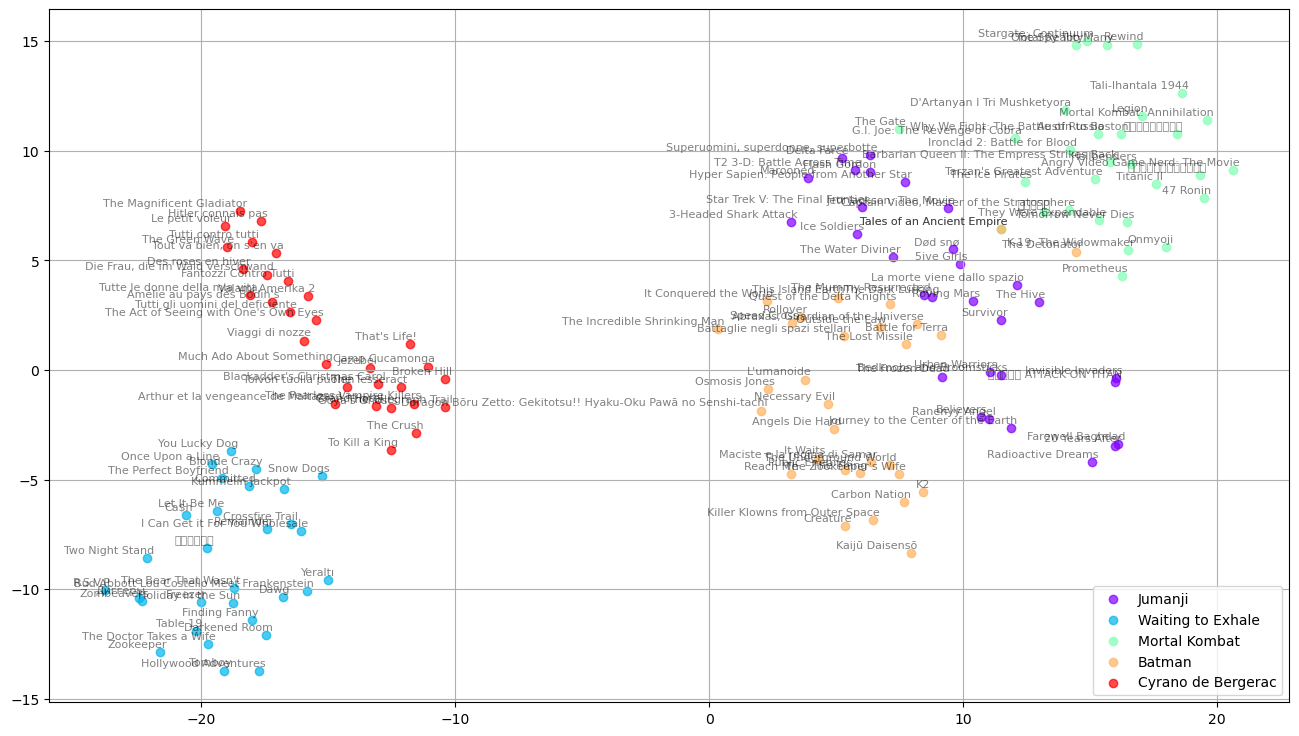

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

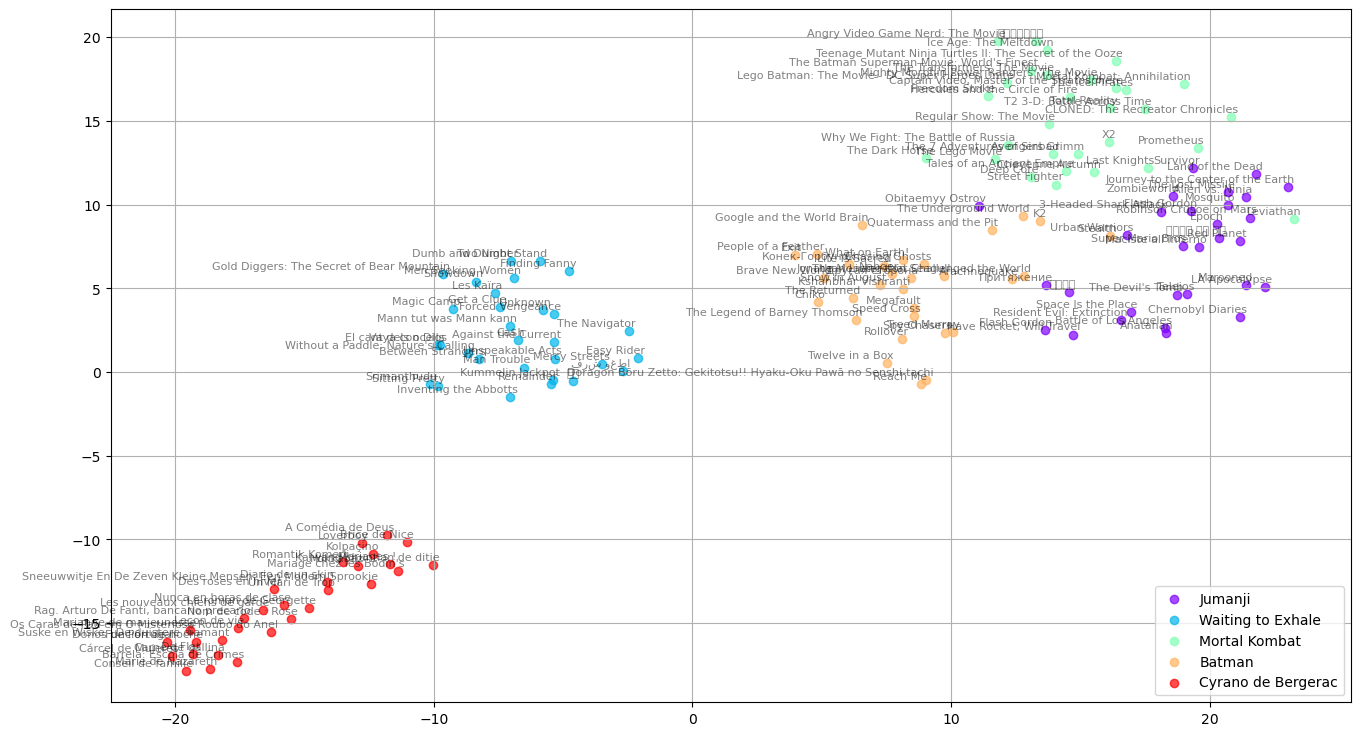

In [529]:
tsne_plot_similar_words(keys, embeddings_en_2d_m1, word_clusters_m1)
tsne_plot_similar_words(keys, embeddings_en_2d_m2, word_clusters_m2)

Here are graphs of model results. Second model shows the results in more group way.